In [6]:
!pip install roboflow

In [7]:
from roboflow import Roboflow
rf = Roboflow(api_key="tXr10qCHwVjmdrbIAB2m")
project = rf.workspace("groceries-wuijx").project("grocery-items-mcqvf")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to grocery-items-2 in yolov8:: 100%|██████████| 16750/16750 [00:03<00:00, 5109.93it/s]


# **Rename Dataset Folder**

In [8]:
import os

old_name = 'grocery-items-2'
new_name = 'Grocery_Detection_Datasets'

if os.path.exists(old_name) and not os.path.exists(new_name):
    os.rename(old_name, new_name)
    print("Folder renamed successfully.")
else:
    print("Rename skipped (source not found or already renamed).")


Folder renamed successfully.


## **Importing libraries**

In [4]:
import torch
import cv2
import os

import torchvision
# Provides datasets, model architectures (like SSD, Faster R-CNN),
# and image transformation utilities for computer vision tasks.

from torch.utils.data import DataLoader
# DataLoader helps load data in batches during training or inference,
# making data processing faster and more efficient.

from torchvision.transforms import transforms
# Contains image preprocessing functions such as resize, normalize,
# tensor conversion, and data augmentation.

from torchvision.models.detection.ssd import SSDClassificationHead
# Defines the classification head of the SSD model,
# responsible for predicting class scores for each anchor box.

from torchvision.models.detection import _utils
# Internal utility functions used by torchvision detection models
# (e.g., box matching, loss helpers).

from torchvision.models.detection import SSD300_VGG16_Weights
# Provides pre-trained weights for the SSD300 model with VGG16 backbone,
# trained on the COCO dataset.


## **Create customdataset class**

In [ ]:
# CustomDataset class is created to load images and their corresponding
# annotation files, convert them into tensors, and return them in a format
# that PyTorch object detection models can understand during training.


class CustomDataset():
    def __init__(self, image_dir, annotations, annotations_dir, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get annotation file name
        annotation = self.annotations[idx]
        # Get image path
        img_path = os.path.join(self.image_dir, annotation[:-4] + '.jpg')

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image {img_path} not found.")

        # Convert image channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get image dimensions
        height, width, _ = image.shape

        # Parse the annotation file
        annotation_file = os.path.join(self.annotations_dir, annotation)
        boxes = []
        labels = []

        # Open annotation file
        with open(annotation_file, "r") as f:
            for line in f:
                # Split data
                data = line.strip().split()
                class_index = int(data[0])  # Class index
                x_center = float(data[1]) * width
                y_center = float(data[2]) * height
                box_width = float(data[3]) * width
                box_height = float(data[4]) * height

                # Convert to absolute coordinates [xmin, ymin, xmax, ymax]
                xmin = x_center - box_width / 2
                ymin = y_center - box_height / 2
                xmax = x_center + box_width / 2
                ymax = y_center + box_height / 2

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(int(class_index + 1))

        # Convert to PyTorch tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Create target dictionary
        target = {"boxes": boxes, "labels": labels}

        return image, target



## **Load Pretrained Model and Modify for Custom Classes**

In [2]:
# Function to create the SSD model
def create_model(num_classes=2, size=300):
    # Load a pre-trained SSD model (SSD300 with VGG16 backbone)
    model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)
    # Explanation: The `ssd300_vgg16` model is a version of SSD with a VGG16 backbone, pre-trained on the COCO dataset.

    # print(model)

    # Retrieve the number of output channels from the backbone given the input size
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    # Explanation: This gets the number of channels coming out of the backbone by passing the desired input size. This is important for modifying later layers.

    # print("inchannels ==> \n\n",in_channels)

    # Get the number of anchors per location from the model's anchor generator
    num_anchors = model.anchor_generator.num_anchors_per_location()
    # Explanation: SSD uses anchor boxes at different aspect ratios and scales. This line retrieves the number of anchors generated by the model.

    # print("anchors ==> \n\n",num_anchors)

    # Replace the classification head to accommodate the number of classes
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes
    )
    # Explanation: The `classification_head` is replaced with a new one that matches the number of classes defined by `num_classes`. It uses the number of channels from the backbone and the number of anchors.

    # Adjust the transform sizes to match the input size
    model.transform.min_size = (size,)
    model.transform.max_size = size
    # Explanation: These lines modify the model's transform settings to adjust the input image sizes. `min_size` and `max_size` determine the resizing behavior.

    # Return the modified model
    return model

# Main block to initialize and print the model
model = create_model(num_classes=18, size=640)

# print(model)
# Explanation: This prints the architecture of the created model.


NameError: name 'torchvision' is not defined

In [ ]:
print(model)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

## **Creating the Dataloader**

In [ ]:
# Step 4: Dataset and DataLoader

## TRAIN DATALOADER
train_image_dir = "Grocery_Detection_Datasets/train/images"
train_annotation_dir = "Grocery_Detection_Datasets/train/labels"
train_annotations = os.listdir(train_annotation_dir)

train_dataset = CustomDataset(train_image_dir, train_annotations, train_annotation_dir, transform=transforms.ToTensor())

# Creates a DataLoader that loads training data in batches of 4,
# shuffles the data each epoch, and uses a custom collate function
# to group images and targets separately (useful when samples have
# different sizes, e.g., in object detection).
train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)


In [ ]:
print(len(train_data_loader))

1570


## **Setting LR OPTIM**

In [ ]:
# Step 5: Training Setup

# Selects GPU (CUDA) if available, otherwise falls back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Moves the model parameters to the selected device (GPU/CPU)
model.to(device)

# Collects only the parameters that require gradient updates (trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]

# SGD optimizer updates model weights using gradients;
# learning rate controls update size, momentum speeds up convergence
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)

# Sets a learning rate scheduler that reduces LR by a factor of 0.1 every 3 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Number of times the entire training dataset will be passed through the model
num_epochs = 5



# Epoch 1, LR: 0.001000
# Epoch 2, LR: 0.001000
# Epoch 3, LR: 0.001000
# Epoch 4, LR: 0.001 * 0.1 ==   0.000100
# Epoch 5, LR: 0.000100
# Epoch 6, LR: 0.000100
# Epoch 7, LR: 0.0001 * 0.1 == 0.000010

## **Checking Dataloader**

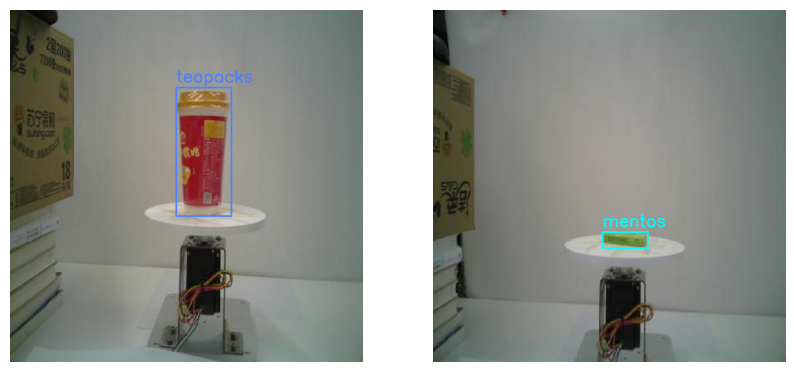

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.ravel()

# Get a batch of images and targets
data_loader_iter = iter(train_data_loader)
images, targets = next(data_loader_iter)

cls_names = [
    'bg','biscuits','can','chips','chocolate','dryfruitpacks','mentos',
    'oilpacks','smallpackdrinks','soaps','soda','softdrinks',
    'solidpackings','soups','stationary','sticksnacks',
    'teapacks','toothitems'
]

# Colors in BGR format for OpenCV
color_sample = [
    (0,0,255), (0,255,0), (255,0,0), (255,255,0), (255,0,255),
    (0,255,255), (0,0,0), (0,165,255), (128,0,128), (203,192,255),
    (42,42,165), (0,255,0), (128,0,0), (128,128,0),
    (0,215,255), (80,127,255), (128,128,128)
]

# Plot images
for idx in range(2):

    # Convert tensor → NumPy → uint8
    image = images[idx].permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8).copy()

    target = targets[idx]
    boxes = target["boxes"].numpy().astype(int)
    labels = target["labels"].numpy()

    # Draw bounding boxes using OpenCV
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        # label starts from 1 (because 0 is reserved for background class 'bg')
        # but Python lists are 0-indexed (first element is at index 0)
        # so we subtract 1 to correctly map the class label to the color list index
        color = color_sample[label - 1]


        # Draw rectangle
        cv2.rectangle(
            image,
            (xmin, ymin),
            (xmax, ymax),
            color,
            thickness=2
        )

        # Put class name text
        cv2.putText(
            image,
            cls_names[label],
            (xmin, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            color,
            2
        )

    # Show image
    ax[idx].imshow(image)
    ax[idx].axis("off")

plt.show()


In [ ]:
from tqdm import tqdm

train_loss = []

for epoch in range(num_epochs):

    print(f"\nStarting the training of Epoch_{epoch+1}.....")
    model.train()

    train_running_loss = 0.0

    pbar = tqdm(
        train_data_loader,
        total=len(train_data_loader),
        desc=f"Epoch [{epoch+1}/{num_epochs}] Training",
        leave=True
    )

    for images, targets in pbar:
        # Move data to device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Total loss (sum of all components)
        losses = sum(loss for loss in loss_dict.values())

        # Weight update formula:
        # new_weight = old_weight - learning_rate * gradient

        # Gradient: tells how much and in which direction a weight should change
        # to reduce the loss

        optimizer.zero_grad()   # Clear previously stored gradients
        losses.backward()       # Compute gradients for all weights
        optimizer.step()        # Update weights using: weight = weight - lr * gradient


        # Accumulate batch loss
        batch_loss = losses.item()
        train_running_loss += batch_loss

    # Step LR scheduler after epoch
    scheduler.step()

    # Correct epoch loss (average over batches)
    epoch_loss = train_running_loss / len(train_data_loader)
    train_loss.append(epoch_loss)

    print(f"Train_Loss: {epoch_loss:.4f}")



Starting the training of Epoch_1.....


Epoch [1/5] Training: 100%|██████████| 1570/1570 [04:27<00:00,  5.87it/s]


Train_Loss: 2.8810

Starting the training of Epoch_2.....


Epoch [2/5] Training: 100%|██████████| 1570/1570 [04:31<00:00,  5.78it/s]


Train_Loss: 2.2490

Starting the training of Epoch_3.....


Epoch [3/5] Training: 100%|██████████| 1570/1570 [04:29<00:00,  5.82it/s]


Train_Loss: 1.8448

Starting the training of Epoch_4.....


Epoch [4/5] Training: 100%|██████████| 1570/1570 [04:29<00:00,  5.82it/s]


Train_Loss: 1.1752

Starting the training of Epoch_5.....


Epoch [5/5] Training: 100%|██████████| 1570/1570 [04:29<00:00,  5.82it/s]

Train_Loss: 1.0544


#**Save Model**

In [ ]:
# Step 7: Save Trained Model
torch.save(model.state_dict(), "SSD_custom.pth")

#**Plort train_loss Graph**

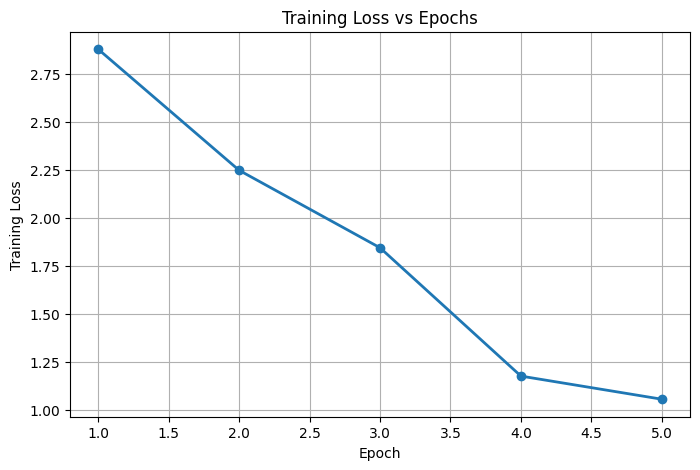

In [ ]:
import matplotlib.pyplot as plt

# Example: train_loss = [2.34, 1.98, 1.65, 1.42, 1.20, 1.05, 0.92, 0.81, 0.73, 0.65]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")

plt.grid(True)
plt.show()


#**Testing**

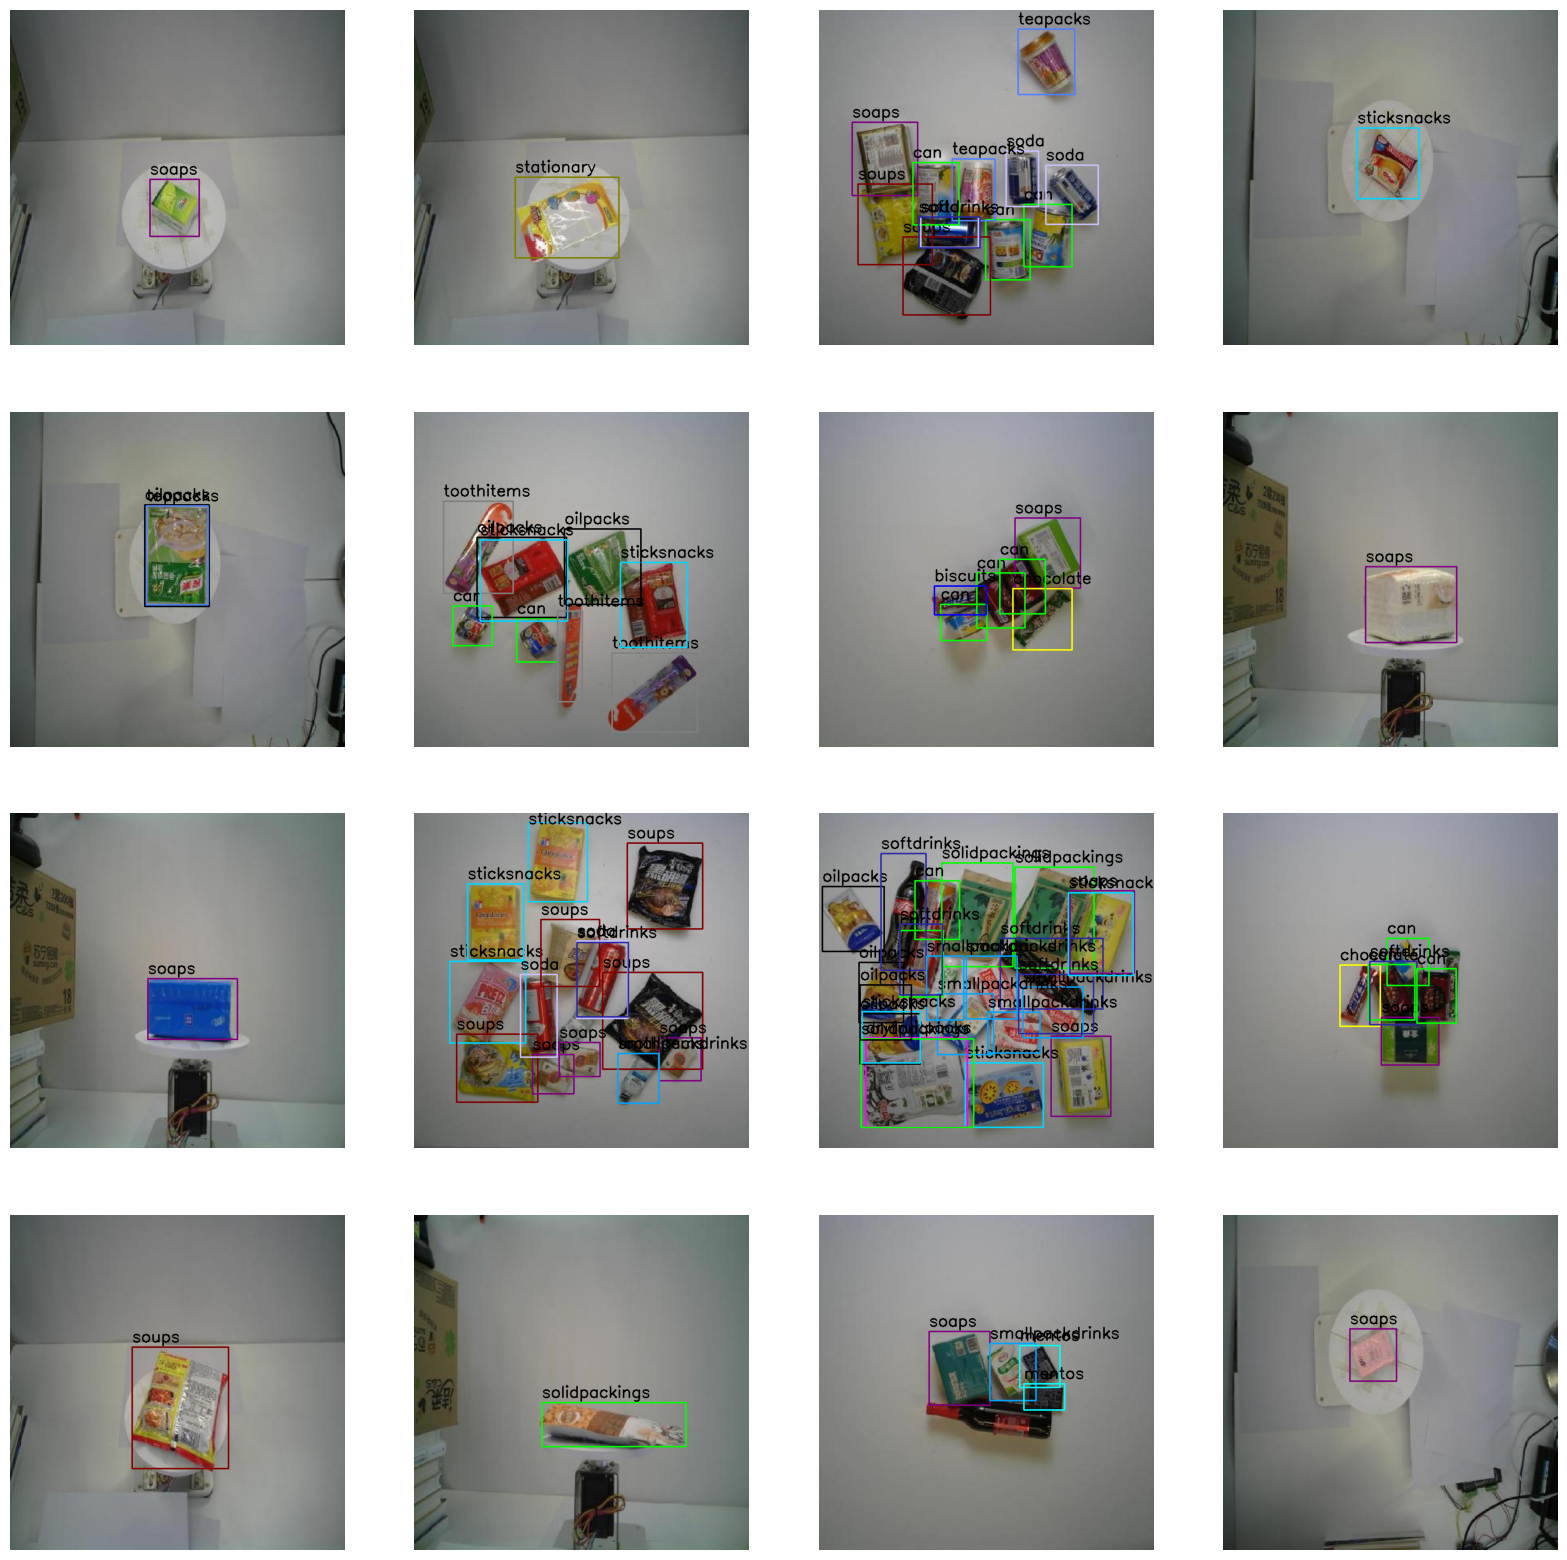

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import os
import torch
from torchvision.transforms import transforms

# ---------------- Model ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model(num_classes=18, size=640)
model.load_state_dict(torch.load("SSD_custom.pth"))
model.eval()
model.to(device)

# ---------------- Plot ----------------
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.ravel()

transform = transforms.ToTensor()

test_dir = "Grocery_Detection_Datasets/test/images"
test_list_file = os.listdir(test_dir)

cls_names = [
    'bg','biscuits','can','chips','chocolate','dryfruitpacks','mentos',
    'oilpacks','smallpackdrinks','soaps','soda','softdrinks',
    'solidpackings','soups','stationary','sticksnacks',
    'teapacks','toothitems'
]

# OpenCV colors → BGR
color_sample = [
    (0,0,255), (0,255,0), (255,0,0), (255,255,0), (255,0,255),
    (0,255,255), (0,0,0), (0,165,255), (128,0,128), (203,192,255),
    (42,42,165), (0,255,0), (128,0,0), (128,128,0),
    (0,215,255), (80,127,255), (128,128,128)
]

# ---------------- Inference Loop ----------------
for idx in range(16):

    img_path = os.path.join(test_dir, random.choice(test_list_file))
    pil_img = Image.open(img_path).convert("RGB")

    img = np.array(pil_img)

    image = transform(pil_img)
    image_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    # Convert tensor → NumPy → uint8
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 255).astype(np.uint8)

    boxes = prediction["boxes"].cpu().numpy().astype(int)
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    # Draw boxes using OpenCV
    for box, label, score in zip(boxes, labels, scores):

        if score < 0.3:
            continue

        color = color_sample[label - 1]  # label starts from 1
        xmin, ymin, xmax, ymax = box

        # Bounding box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            thickness=2
        )

        # Class label text
        cv2.putText(
            img,
            cls_names[label],
            (xmin, max(ymin - 10, 20)),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0,0,0),
            2
        )

    ax[idx].imshow(img)
    ax[idx].axis("off")

plt.show()
